# ASLingo Model Training

This notebook trains the model used in the ASLingo backend. It assumes that `data_collection.py` has been run and the data is saved in the data/ folder.

In [1]:
import pandas as pd
import numpy as np
import os
import time
import json

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
metadata_path = os.path.join('data', 'metadata.json')
with open(metadata_path) as f:
    metadata = json.load(f)
words = list(metadata.keys())

In [4]:
def get_csv_path(word, sample_idx=0):
    return os.path.join('data', word, f"{sample_idx}.csv")

## Data Preprocessing

In [5]:
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()
encoder.fit(words)

LabelEncoder()

In [6]:
encoder.transform(['LETTER-A'])

array([0])

In [7]:
encoder.inverse_transform([9])

array(['LETTER-J'], dtype='<U8')

In [268]:
class StaticSignProcessor():
    def __init__(self, X_shape=(10,126,1)):
        self.shape = X_shape
    
    def process(self, df):
        '''
        just the cleanup: cut out head and tail, fill nan, (normalize)
        '''

        norm_df_array = self.normalize(df, method='hand_bbox')
        norm_df = pd.DataFrame(data=norm_df_array, columns=df.columns)
    
        # Drop the frames in the beginning and end of the video where no hands are detected
        # Drop the timeframe and pose data
        start_idx = (~norm_df['lefthand_0_x'].isna() | ~norm_df['righthand_0_x'].isna()).argmax()
        end_idx = len(norm_df) - (norm_df[::-1]['lefthand_0_x'].isna() & norm_df[::-1]['righthand_0_x'].isna()).argmin()
        
        norm_df = norm_df.iloc[start_idx:end_idx,1:127]

        # Fill empty values with the previous seen value
        norm_df = norm_df.fillna(method='ffill').fillna(method='bfill').fillna(0.)

        # For classifiers, just return the mean of each column
        if self.shape == (126,):
            return norm_df.mean().to_numpy()

        # for now, just choose 10 frames from the middle
#         data = df.iloc[len(df)//3:len(df)//3+10].mean().to_numpy()
#         if sum(np.isnan(data)) != 0:
#             print(sum(np.isnan(data)))
#         norm_data = np.reshape(data, self.shape)
#         assert data.shape == self.shape
#         return data

    def normalize(self, df, method='hand_bbox'):
        df_array = df.to_numpy().T  # shape: (202,num_frames)

        if method=='hand_bbox':
            for h in ['left','right']:
                hand_x_df = df.filter(regex=h).filter(regex='_x')
                hand_y_df = df.filter(regex=h).filter(regex='_y')
                x1,y1,x2,y2 = hand_x_df.min().min(),hand_y_df.min().min(),hand_x_df.max().max(),hand_y_df.max().max()

                x_cols = [df.columns.get_loc(col) for col in hand_x_df.columns]
                y_cols = [df.columns.get_loc(col) for col in hand_y_df.columns]
                df_array[x_cols] = (df_array[x_cols]-min(x1,x2))/(max(x1,x2)-min(x1,x2)+0.000001)
                df_array[y_cols] = (df_array[y_cols]-min(y1,y2))/(max(y1,y2)-min(y1,y2)+0.000001)
        #         df_x = (df.filter(regex='_x')-min(x1,x2))/(max(x1,x2)-min(x1,x2)+0.000001)
        #         df_y = (df.filter(regex='_y')-min(y1,y2))/(max(y1,y2)-min(y1,y2)+0.000001)
            return df_array.T
        elif method=='pose':
            # normalize based on the width of the shoulders and height from shoulders to nose
#             x1,y1,x2,y2 = df[['pose_11_x','pose_0_y','pose_12_x','pose_12_y']].mean()
            hand_x_df = df.filter(regex='_x')
            hand_y_df = df.filter(regex='_y')
            col_indices = [df.columns.get_loc(col) for col in ('pose_11_x','pose_0_y','pose_12_x','pose_12_y')]
            x1,y1,x2,y2 = df_array[col_indices].mean(axis=1)
            x_cols = [df.columns.get_loc(col) for col in hand_x_df.columns]
            y_cols = [df.columns.get_loc(col) for col in hand_y_df.columns]
            df_array[x_cols] = (df_array[x_cols]-min(x1,x2))/(max(x1,x2)-min(x1,x2)+0.000001)
            df_array[y_cols] = (df_array[y_cols]-min(y1,y2))/(max(y1,y2)-min(y1,y2)+0.000001)
            return df_array.T
    
    def flip_hands(self, df_array):
        assert len(df_array) == 126
        return np.concatenate((df_array[len(df_array)//2:],df_array[:len(df_array)//2]))
    
    def generate_more_data(self, df_array, n=10, std=0.1):
        '''
        Generate more data from a single sample by adding noise
        '''
        samples = []
        
        for i in range(n):
            noise = np.random.normal(0, std, df_array.shape)
            # randomly select up to 5 joints to perturb
            perturb_indices = np.random.choice(len(df_array.T), np.random.choice(5), replace=False)
            df_array.T[perturb_indices] = df_array.T[perturb_indices] + np.random.normal(0, std, df_array.T[perturb_indices].shape)
            samples.append(df_array + noise)

        return samples
    
    

In [269]:
tmp = StaticSignProcessor(X_shape=(126,))
tmp.process(df)

array([ 5.14428784e-01,  8.10082251e-01, -1.61493887e-05,  6.40939020e-01,
        9.13120719e-01, -3.37150847e-02,  7.30680673e-01,  9.21237286e-01,
       -6.17546300e-02,  7.51557225e-01,  9.09874292e-01, -8.36908787e-02,
        7.18530059e-01,  9.11446348e-01, -1.05298066e-01,  7.72780265e-01,
        6.19023175e-01, -7.72599476e-02,  8.37492151e-01,  4.57637032e-01,
       -1.03693309e-01,  7.45095682e-01,  5.49685577e-01, -1.19561778e-01,
        6.64538202e-01,  6.83228314e-01, -1.29985066e-01,  6.64400845e-01,
        4.50042582e-01, -7.20591027e-02,  7.04795129e-01,  2.36105751e-01,
       -9.80816517e-02,  6.15399087e-01,  3.33832622e-01, -1.13899388e-01,
        5.48612828e-01,  4.78447554e-01, -1.28249610e-01,  5.48617141e-01,
        3.60934614e-01, -6.62375962e-02,  5.63165195e-01,  1.50704210e-01,
       -8.81514316e-02,  4.79567718e-01,  2.36919633e-01, -1.02384487e-01,
        4.21683284e-01,  3.64646456e-01, -1.13259777e-01,  4.41923582e-01,
        3.32937958e-01, -

In [270]:
lstm_data_shape = (10,126)
cnn_data_shape = (10,126,1)
classifier_data_shape = (126,)
data_processor = StaticSignProcessor(X_shape=classifier_data_shape)

In [287]:
X_data = []
y_data = []

for word in words:
    for file in os.listdir(os.path.join('data', word)):
        df = pd.read_csv(os.path.join('data', word, file))
        df_array = data_processor.process(df)
        X_data.append(df_array)
        X_data += data_processor.generate_more_data(df_array, n=10, std=0.02)
        y_data += [word] * 11
        flipped_data = data_processor.flip_hands(df_array)
        X_data.append(flipped_data)
        X_data += data_processor.generate_more_data(flipped_data, n=10, std=0.02)
        y_data += [word] * 11


#         df = preprocess(df)
#         df_array = normalize(df, num_rows=50, mode='static')
#         # for lda
#         df_array = df_array.flatten()
#         X_data.append(df_array)
#         X_data += generate_more_data(df_array, n=20)
#         y_data += [word] * 21
        
X_data = np.array(X_data)
# for cnn model
# X_data = np.reshape(X_data, (X_data.shape[0], 10, 126, 1))
y_data = np.vstack(encoder.transform(y_data))
print(X_data.shape)
print(y_data.shape)

#     df_train = pd.read_csv(get_data_path(word, 0))
#     df_train = clean_df(df_train)
#     samples = generate_more_data(df_train)
#     X_train.append(clean_df(df_train))
#     y_train.append(word)
    
#     df_test = pd.read_csv(get_data_path(word, 1))
#     X_test.append(clean_df(df_test))
#     y_test.append(word)

# X_train = np.array(X_train)
# X_test = np.array(X_test)
# y_train = encoder.transform(y_train)
# y_test = encoder.transform(y_test)

(1716, 126)
(1716, 1)


In [288]:
max(X_data[0])

0.9329272173152162

In [289]:
for i,x in enumerate(X_data):
    if sum(np.isnan(x)) != 0:
        print(i)
        print(x)
# pd.read_csv(get_data_path(sampled_words[18]))[['lefthand_0_x','righthand_0_x']].mean().fillna(0)

In [14]:
y_data.shape

(1716, 1)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_data, 
                                                        y_data,
                                                        stratify=y_data, 
                                                        test_size=0.25)

In [123]:
X_train.shape

(1287, 126)

## Model Selection

In [15]:
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, Flatten, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import optimizers
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

In [17]:
def lstm_model():
    # from MP2
    batch_size=50
    epochs=50
    latent_dim=128

#     input_layer = Input(shape=X_data.shape[1:])
#     lstm = LSTM(latent_dim)(input_layer)
#     dense = Dense(latent_dim, activation='relu')(lstm)
#     pred = Dense(len(sampled_words), activation='softmax')(dense)

    model = Sequential()
    model.add(LSTM(latent_dim))
    model.add(Dense(latent_dim, activation='relu'))
    model.add(Dense(len(words), activation='softmax'))


#     model = Model(inputs=input_layer, outputs=pred)
    model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["acc"])

    model.fit(X_data,
            y_data,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            validation_split=0.3,
            shuffle=True)

    print(model.summary())
    return model

lstm_model()

Epoch 1/50


ValueError: in user code:

    /Users/dainkim/miniconda3/envs/asl-downgrade/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /Users/dainkim/miniconda3/envs/asl-downgrade/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/dainkim/miniconda3/envs/asl-downgrade/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/dainkim/miniconda3/envs/asl-downgrade/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/dainkim/miniconda3/envs/asl-downgrade/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /Users/dainkim/miniconda3/envs/asl-downgrade/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:885 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /Users/dainkim/miniconda3/envs/asl-downgrade/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 126]


In [70]:

# y_cat = np_utils.to_categorical(y_data)
# X_train, X_test, y_train, y_test = train_test_split(X_data, 
#                                                         y_cat,
#                                                         stratify=y_cat, 
#                                                         test_size=0.25)



# model = cnn_model()
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

In [64]:
def cnn_model():
    num_of_classes = len(words)
    model = Sequential()
    model.add(Conv2D(16, (2,1), input_shape=(10, 126, 1), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Conv2D(32, (2,1), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(3, 3), strides=(3, 3), padding='same'))
#     model.add(Conv2D(64, (2,1), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(5, 5), strides=(5, 5), padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.2))
    model.add(Dense(num_of_classes, activation='softmax'))
    sgd = optimizers.SGD(lr=1e-2)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# 	filepath="cnn_model_keras2.h5"
# 	checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# 	callbacks_list = [checkpoint1]
	#from keras.utils import plot_model
	#plot_model(model, to_file='model.png', show_shapes=True)
# 	return model, callbacks_list
    print(model.summary())
    return model

In [66]:
y_cat = np_utils.to_categorical(y_data)
X_train, X_test, y_train, y_test = train_test_split(X_data, 
                                                        y_cat,
                                                        stratify=y_cat, 
                                                        test_size=0.25)


epochs=15
batch_size=20

model = cnn_model()
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 9, 126, 16)        48        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 126, 32)        1056      
_________________________________________________________________
flatten_1 (Flatten)          (None, 32256)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4128896   
_________________________________________________________________
dense_3 (Dense)              (None, 26)                3354      
Total params: 4,133,354
Trainable params: 4,133,354
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
33/33 [==============================] - 1s 23ms/step - loss: nan - accuracy: 0.0389 - val_los

In [132]:
model.save('cnn_letters_1.h5')
    
# model.evaluate(val_images, val_labels, verbose=0)

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [290]:
import warnings
warnings.filterwarnings('ignore')

lda_accuracy = []
qda_accuracy = []
knn_accuracy = []
rf_accuracy = []
nb_accuracy = []

for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X_data, 
                                                        y_data,
                                                        stratify=y_data, 
                                                        test_size=0.25)
    
    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train, y_train)
    lda_accuracy.append(clf.score(X_test,y_test))
    
    clf = QuadraticDiscriminantAnalysis()
    clf.fit(X_train, y_train)
    qda_accuracy.append(clf.score(X_test,y_test))
    
    neigh = KNeighborsClassifier(n_neighbors=15)
    neigh.fit(X_train, y_train)
    knn_accuracy.append(neigh.score(X_test,y_test))
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
    clf.fit(X_train, y_train)
    rf_accuracy.append(clf.score(X_test,y_test))

    clf = GaussianNB()
    clf.fit(X_train, y_train)
    nb_accuracy.append(clf.score(X_test,y_test))    

In [291]:
accuracy_list = [qda_accuracy, nb_accuracy, knn_accuracy, rf_accuracy, lda_accuracy]

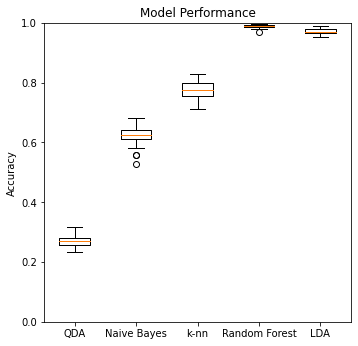

In [292]:
plt.figure(figsize=(5.5, 5.5))
plt.ylim(0, 1)
plt.boxplot(accuracy_list, labels = ['QDA', 'Naive Bayes', 'k-nn', 'Random Forest', 'LDA'])
plt.title('Model Performance')
plt.ylabel('Accuracy')
# plt.savefig('plots/two_hand_model_performance.png', dpi = 500)
plt.show()

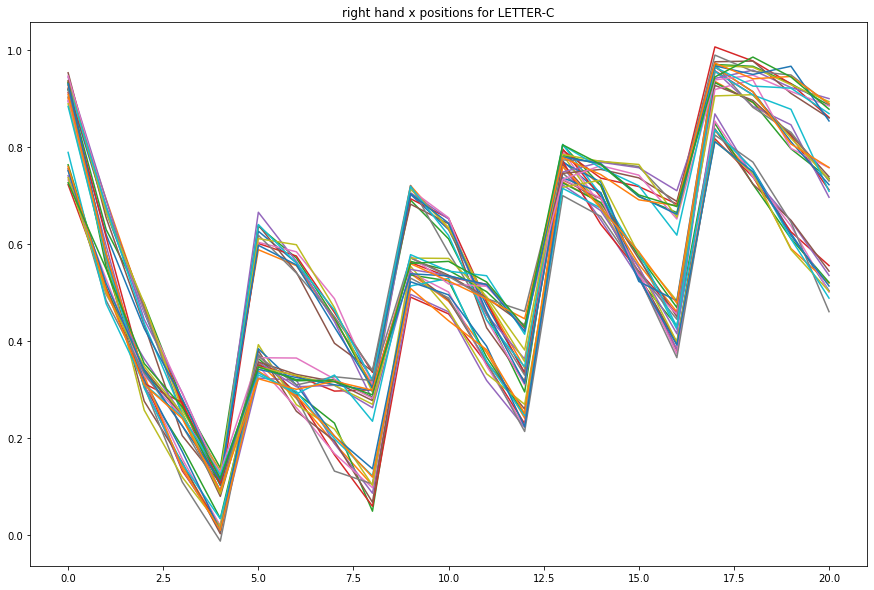

In [293]:
plt.figure(figsize=(15,10))
# word = encoder.transform([np.random.choice(sampled_words)])[0]
word = encoder.transform(['LETTER-C'])[0]
samples = X_data[(y_data==word).flatten()]
samples = np.concatenate((samples[:11], samples[22:33], samples[44:55]))
# for x in samples[np.random.choice(len(samples), 10, replace=False)]:
for x in samples:
    plt.title('right hand x positions for {}'.format(encoder.inverse_transform([word])[0]))
    plt.plot(np.arange(len(x)//6), x[len(x)//2::3])
plt.show()


In [294]:
import pickle

X_train, X_test, y_train, y_test = train_test_split(X_data, 
                                                        y_data,
                                                        stratify=y_data, 
                                                        test_size=0.25)
print(X_train[0].shape)
# model = KNeighborsClassifier(n_neighbors=15)
# model.fit(X_train, y_train)
# model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
# model.fit(X_train, y_train)
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)
print(model.score(X_test,y_test))
pred_prob = model.predict_proba([X_test[0]])[0]
pred_class = list(pred_prob).index(max(pred_prob))
print(encoder.inverse_transform([pred_class]))
print(max(pred_prob))


# Its important to use binary mode
knnPickle = open('saved_model.pkl', 'wb')

# source, destination
pickle.dump(model, knnPickle)
knnPickle.close()

(126,)
0.9743589743589743
['LETTER-B']
0.9999999994579034


In [283]:
from sklearn.preprocessing import StandardScaler

def return_features(df_list, hand_list, drop_left):
    scaler = StandardScaler()
    
    feature_list = []
    
    select_class = hand_selection(drop_left)
    frames = select_class.transform(df_list, hand_list)
    
    for df in frames:
        class_obj = extraction(df)
        class_obj.extract_features()
        feature_list.append(class_obj.features)
        
    feat_df = pd.DataFrame(feature_list)
    
    y = feat_df.label
    X = scaler.fit_transform(feat_df.drop(['label'], axis = 1))
    
    return X, y

In [58]:
nb_accuracy[0]

1.0

In [66]:
def get_dfs_for_sign(sign):
    label = encoder.transform([sign])[0]
    samples = X_data[(y_data==label).flatten()]
    return samples


In [65]:
from matplotlib.path import Path
import matplotlib.patches as patches


def visualize_hands(df_array):
#     plt.figure(figsize=(15,15))
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
    ax = ax1
    for hand in (df_array[:len(df_array)//2], df_array[len(df_array)//2:]):
        hand_data = []
        finger_data = []
        for i in range(len(hand)//3):
            x,y,z = df_array[3*i:3*(i+1)]
            if i % 4 == 0 and i != 0:
                finger_data.append([x,y])
            else:
                hand_data.append([x,y])
#         hand_data = max(hand_data) - np.array(hand_data)
#         finger_data = max(finger_data) - np.array(finger_data)
        ax.scatter(np.array(hand_data).T[0], np.array(hand_data).T[1], color='blue')
        ax.scatter(np.array(finger_data).T[0], np.array(finger_data).T[1], color='red')
#         verts = np.array(hand_data)
#         codes = [Path.MOVETO] + [Path.LINETO] * (len(verts)-2) + [Path.CLOSEPOLY]
#         path = Path(verts, codes)
#         patch = patches.PathPatch(path, lw=2)
#         ax.add_patch(patch)
        ax = ax2
    
    plt.show()
            

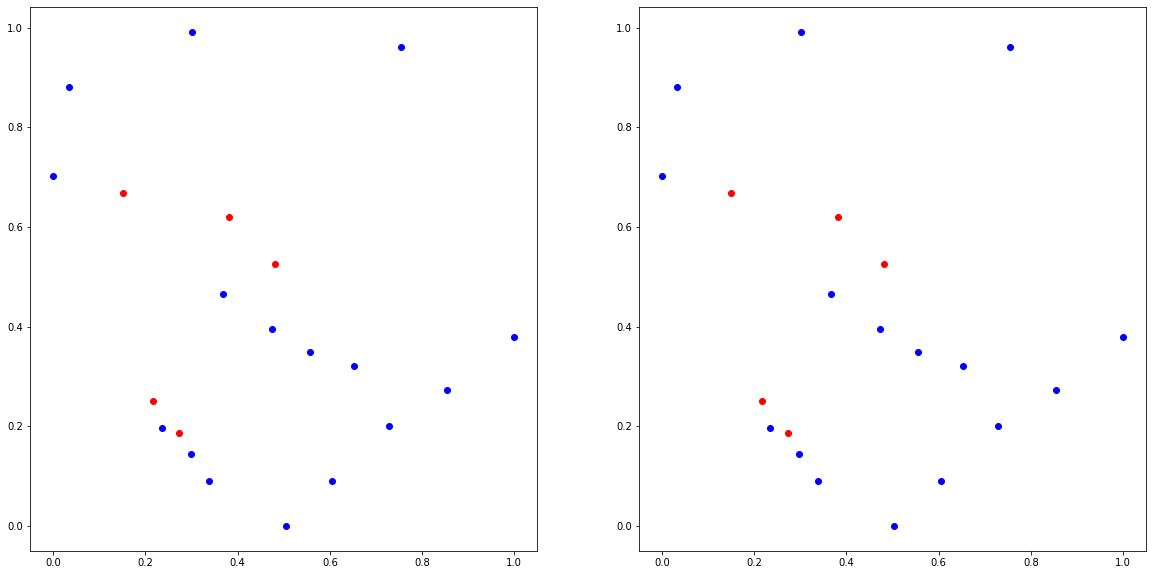

In [76]:
letter_data = get_dfs_for_sign('LETTER-X')
visualize_hands(letter_data[22])